## Задача:
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных:

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План работы:

- Загрузим данные.
- Проведем первичный анализ данных.
- Изучим производственные процессы и исходные данные.
- Проведем исследовательский анализ данных.
- Подготовим данные (определим признаки необходимые для модели)
- Сделаем сводную таблицу
- Используем  XGBoost, CatBoost, LinearRegression с подбором нужных параметров.
- Сравним резльтаты моделей и выберем лучшую.
- Проверим на тестовой выборке.
- Напишем отчет.


## Первичный анализ данных.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from pathlib import Path
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import xgboost
import numpy as np

Загрузим данные 

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
def df_info(df):
        df.info()
        display(df.head(10))
        display(df.describe())
        print('Кол-во дубликатов:', df.duplicated().sum())
        print()
        print('Кол-во уникальных партий:', len(df['key'].unique()))

In [4]:
df_info(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Кол-во дубликатов: 0

Кол-во уникальных партий: 3214


- Почти 15 тысяч строк и 5 столбцов.
- В данных нет дубликатов и пропусков.
- Аномальное минимальное значение у реактивной мощности.
- Нужно изменить тип данных у двух столбцов "Начало нагрева дугой" и "Конец нагрева дугой" на `datetime`.
- Кол-во уникальных партий 3214.

In [5]:
df_info(bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Кол-во дубликатов: 0

Кол-во уникальных партий: 3129


- Имеем 3129 строк и 16 столбцов.
- Дубликаты отсутствуют.
- Большое кол-во пропусков во всех столбцах кроме "Key".
- Верный тип данных.
- Кол-во уникальных партий 3129.

In [6]:
df_info(bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Кол-во дубликатов: 0

Кол-во уникальных партий: 3129


- Имеем 3129 строк и 16 столбцов.
- Дубликаты отсутствуют.
- Большое кол-во пропусков во всех столбцах кроме "Key".
- Нужно изменить тип данных.
- Кол-во уникальных партий 3129.

In [7]:
df_info(gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Кол-во дубликатов: 0

Кол-во уникальных партий: 3239


- Имеем 3239 строк и 2 столбца.
- Дубликаты и пропуски отсутствуют.
- Кол-во уникальных партий 3239.

In [8]:
df_info(temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Кол-во дубликатов: 0

Кол-во уникальных партий: 3216


- Имеем больше 15 тысяч строк и 3 столбца.
- Дубликаты отсутствуют.
- Есть пропуски в столбце "Температура".
- Нужно изменить тип данных в столбце "Время замера".
- Кол-во уникальных партий 3216.

In [9]:
df_info(wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Кол-во дубликатов: 0

Кол-во уникальных партий: 3081


- Имеем 3081 строку и 10 столбцов.
- Дубликаты отсутствуют.
- Есть пропуски во всех столбцах.
- Кол-во уникальных партий 3081.

In [10]:
df_info(wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Кол-во дубликатов: 0

Кол-во уникальных партий: 3081


- Имеем 3081 строку и 10 столбцов.
- Дубликаты отсутствуют.
- Есть пропуски во всех столбцах.
- Нужно изменить тип данных.
- Кол-во уникальных партий 3081.

## Исследовательский анализ данных.

### arc — данные об электродах;

Изучим данные о мощностях более наглядно

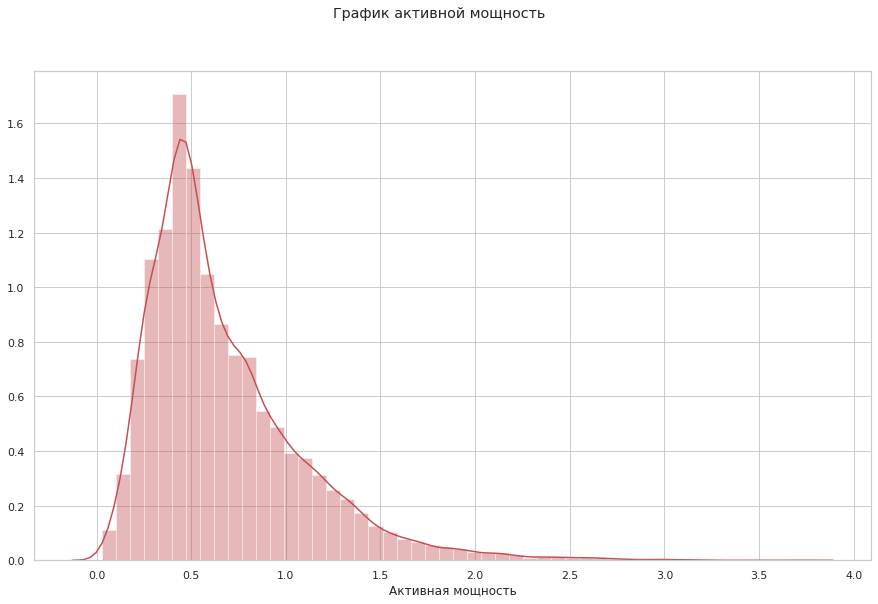

In [11]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharey=True, figsize=(15,9), sharex=True)
sns.distplot(a=arc['Активная мощность'], ax=ax, color="r", kde=True)
ax.set_ylabel('')
fig.suptitle('График активной мощность')
fig.show()

Распределение похоже на нормальное, сдвинутое немного влево

Text(0, 0.5, '')

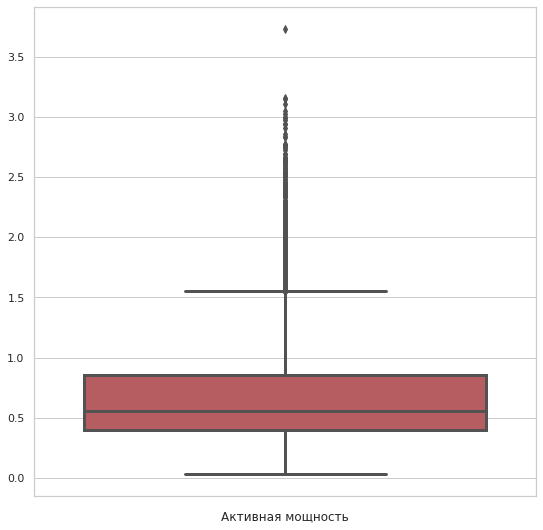

In [12]:
fig, ax = plt.subplots(sharey=True, figsize=(9,9))

sns.boxplot(y='Активная мощность', linewidth=3, data=arc, ax=ax, showfliers=True, color="r")
ax.set_xlabel('Активная мощность')
ax.set_ylabel('')

Медиана примерно находится на уровне 0.6.

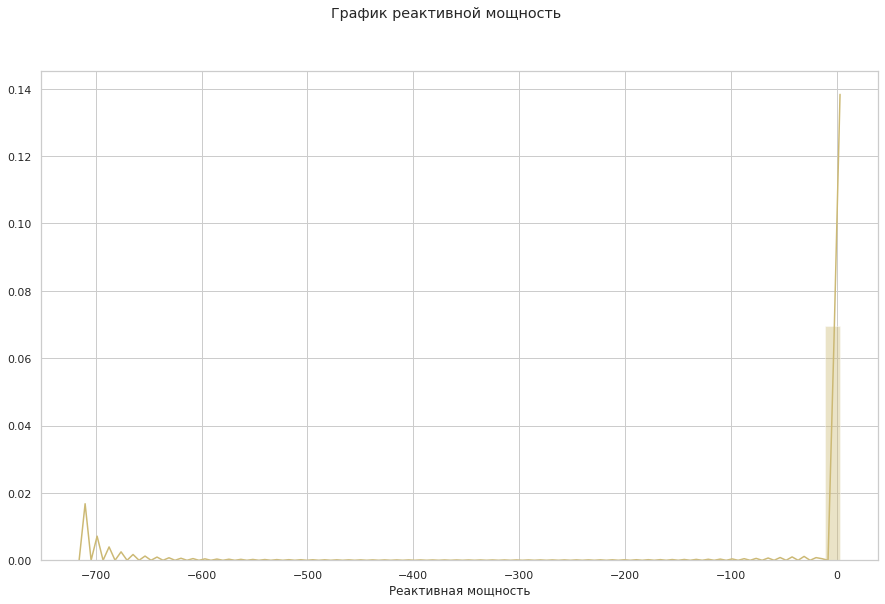

In [13]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharey=True, figsize=(15,9), sharex=True)
sns.distplot(a=arc['Реактивная мощность'], ax=ax, color="y", kde=True)
ax.set_ylabel('')
fig.suptitle('График реактивной мощность')
fig.show()

Большое кол-во аномалий, возьмем значения больше 0, ведь мощность не может быть отрицательной.

In [14]:
arc = arc[arc['Реактивная мощность'] >= 0]

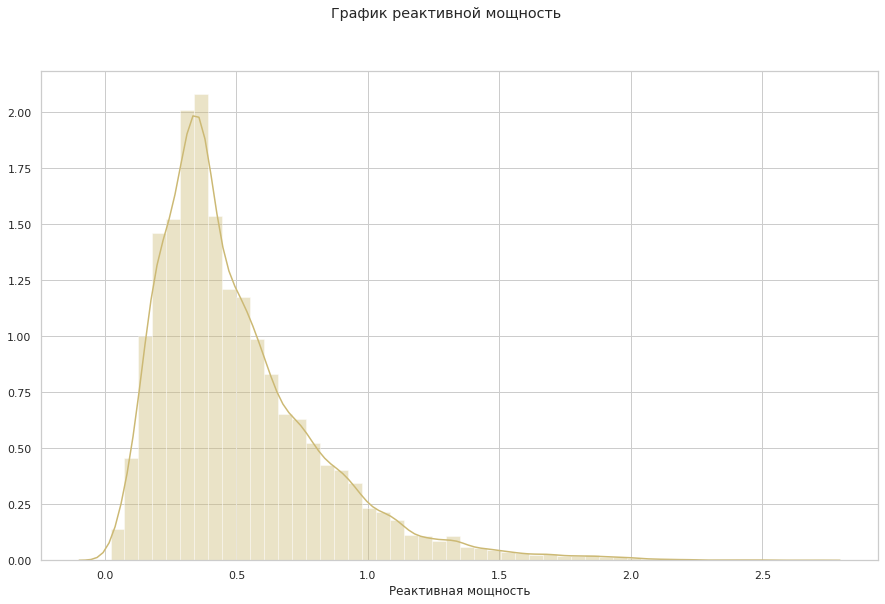

In [15]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharey=True, figsize=(15,9), sharex=True)
sns.distplot(a=arc['Реактивная мощность'], ax=ax, color="y", kde=True)
ax.set_ylabel('')
fig.suptitle('График реактивной мощность')
fig.show()

Имеем нормальное распределение, немного сдвинутое влево.

Text(0, 0.5, '')

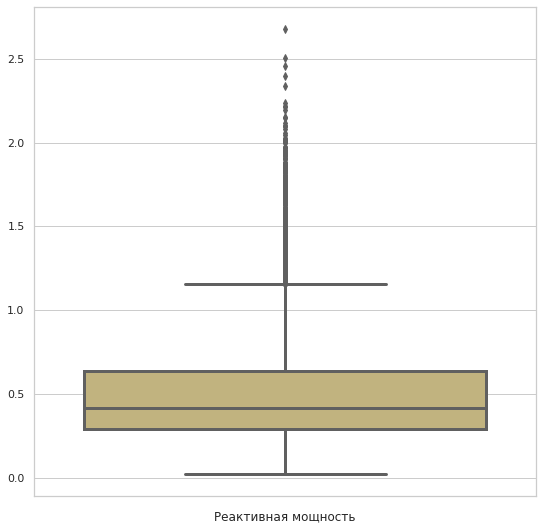

In [16]:
fig, ax = plt.subplots(sharey=True, figsize=(9,9))

sns.boxplot(y='Реактивная мощность', linewidth=3, data=arc, ax=ax, showfliers=True, color = "y")
ax.set_xlabel('Реактивная мощность')
ax.set_ylabel('')

Медиана примерно находится на уровне 0.4

Активная и реактивная мощности имеют сильную зависимость, а значит есть риск переобучаемости модели.

In [17]:
arc[['Реактивная мощность', 'Активная мощность']].corr()

,Реактивная мощность,Активная мощность
Реактивная мощность,1.000000,0.963182
Активная мощность,0.963182,1.000000


Поискав информацию в интернете, я узнал, что эти мощности взаимосвязаны и их можно выразить через полную мощность.

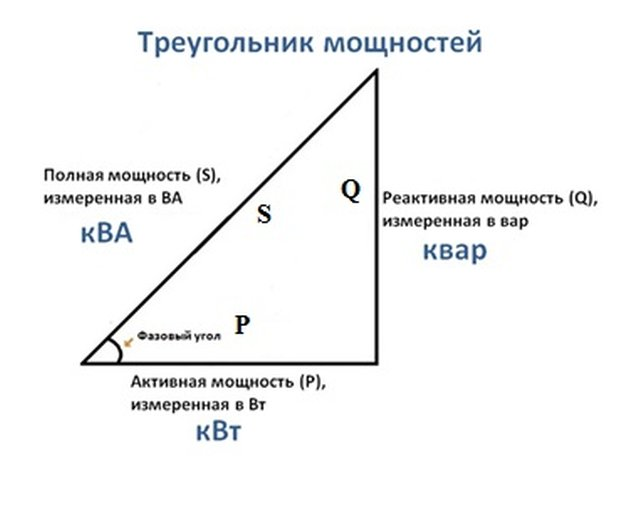

Найдем полную мощность по теореме Пифагора.

In [18]:
def full(df):
    full = math.sqrt(df['Активная мощность']**2 + df['Реактивная мощность']**2)
    return full

In [19]:
arc['Полная мощность'] = arc.apply(full, axis=1)

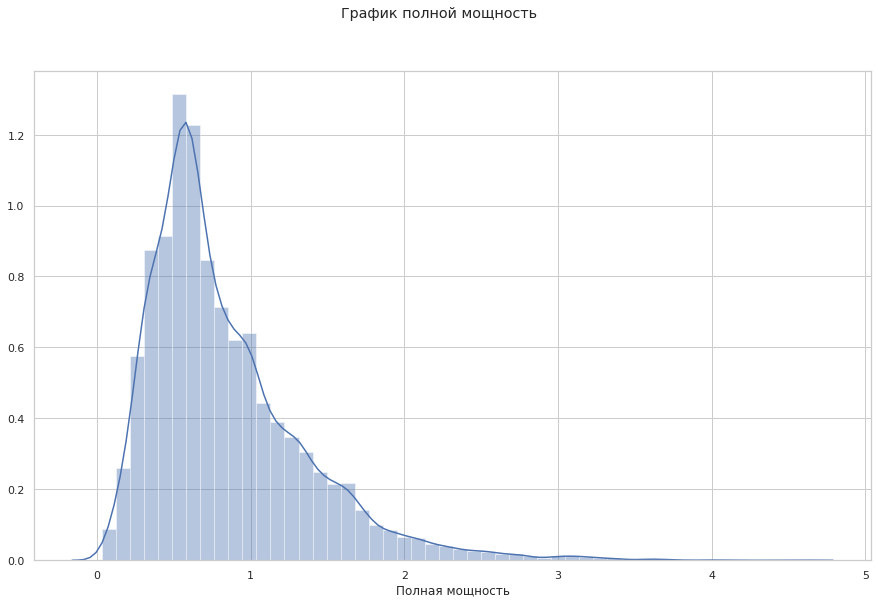

In [20]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharey=True, figsize=(15,9), sharex=True)
sns.distplot(a=arc['Полная мощность'], ax=ax, color="b", kde=True)
ax.set_ylabel('')
fig.suptitle('График полной мощность')
fig.show()

In [21]:
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


В дальнейшем можно убрать данные о Активной и Реактивной мощности, из-за их сильной корреляции.

### temp — результаты измерения температуры

В данных о температуре у нас были пропуски, посмотрим на них.

In [22]:
temp[temp['Температура'].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Можно заметить, что пропуски начинают идти с 2500 партии, возможно в это время что-то случилось. Нужно сообщить об ошибке.

In [23]:
temp[temp['key'] >= 2500].count()

key             3640
Время замера    3640
Температура      739
dtype: int64

Но какие-то значения все же записывались.

In [24]:
temp[temp['key'] >= 2500].head(20)

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12276,2502,2019-08-06 04:45:26,1583.0


Можно заметить, что запись делалась только первой итерации каждой новой партии.

На мой взгляд, просто удалить пропуски нельзя. Возьмем для примера данные о подаче сыпучих материалов (время) 2501 партии.

In [25]:
bulk_time[bulk_time['key'] == 2501].head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2409,2501,NaN,NaN,2019-08-06 04:01:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-06 03:49:53,NaN,2019-08-06 03:49:53,2019-08-06 03:49:53


Если мы удалим пропуски, то в дальнейшем в общей сводной таблице этой партии будет стоять значение температуры до всех подач сыпучих материалов, а значит увеличится риск ошибки. 

Поэтому предлагаю не брать партии дальше 2500.

### gas — данные о продувке сплава газом

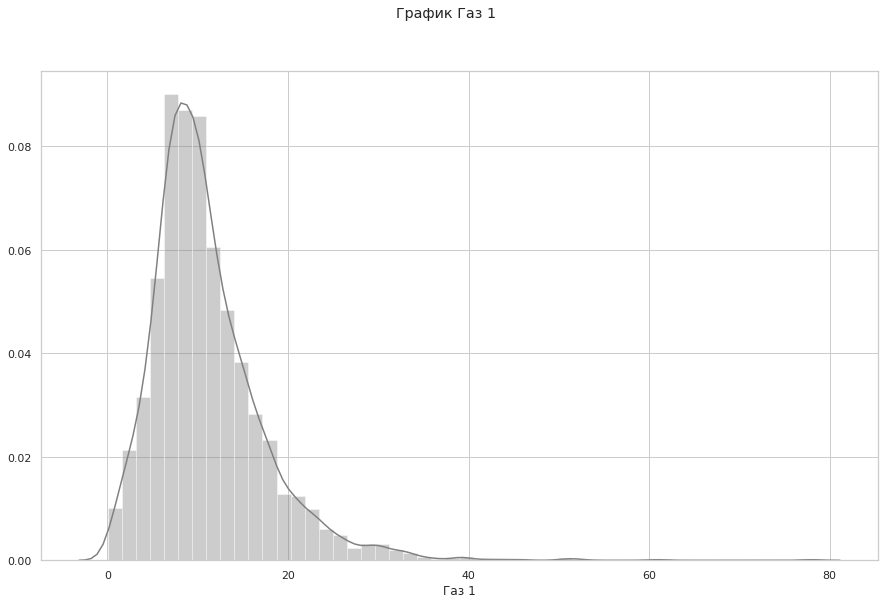

In [26]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharey=True, figsize=(15,9), sharex=True)
sns.distplot(a=gas['Газ 1'], ax=ax, color="grey", kde=True)
ax.set_ylabel('')
fig.suptitle('График Газ 1')
fig.show()

График имеет нормальное распределение.

Text(0, 0.5, '')

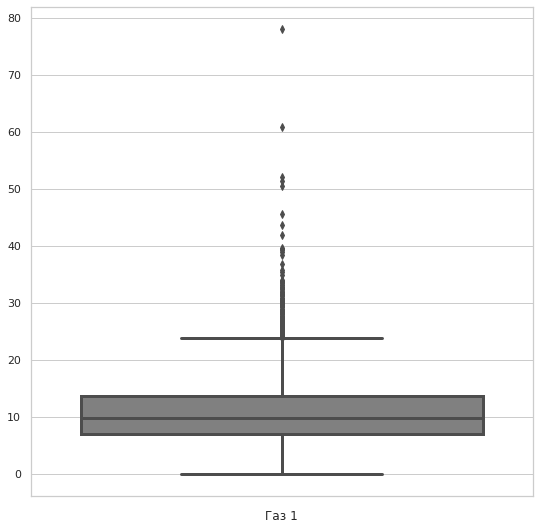

In [27]:
fig, ax = plt.subplots(sharey=True, figsize=(9,9))

sns.boxplot(y='Газ 1', linewidth=3, data=gas, ax=ax, showfliers=True, color = "grey")
ax.set_xlabel('Газ 1')
ax.set_ylabel('')

Медиана примерно равно 10. После 40 наблюдаются редкие аномалии.

### Выводы

- В этом пункте мы провели полный анализ данных
- Выявили и убрали аномалии
- Добавили новый параметр "Полная мощность"
- Решили, что нужно сделать срез данных начиная с 2500-ой партии.

## Предобработка данных

Исправим тип данных у времени

In [28]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

Уберем ненужные строки

In [29]:
temp = temp.query('key < 2500')
arc = arc.query('key < 2500')
bulk = bulk.query('key < 2500')
wire = wire.query('key < 2500')

Заменим пропуски нулями

In [30]:
bulk = bulk.fillna(0)
wire = wire.fillna(0)

In [31]:
temp = temp.sort_values(by=['Время замера'])

Сгруппируем данные в таблице temp по столбцу 'key' и узнаем первую и последнею температуру и время замера для каждой итерации.

In [32]:
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.columns = temp.columns.droplevel()

In [33]:
temp.head()

,,first,last,first,last
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [34]:
temp.columns = ['key', 'Время 1', 'Время 2', 'Температура 1', 'Температура 2']

удалим ненужные столбцы

In [35]:
del temp['Время 1']
del temp['Время 2']

Узнаем сколько всего было итераций у каждой партии

In [36]:
arc_new = arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]

In [37]:
arc_new.head()

,key,Начало нагрева дугой
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


In [38]:
arc_new.columns = ['key', 'Количество итераций']

In [39]:
arc = arc.groupby(by = 'key', as_index = False).sum()

In [40]:
arc.head()

,key,Активная мощность,Реактивная мощность,Полная мощность
0,1,4.878147,3.183241,5.826395
1,2,3.052598,1.998112,3.649216
2,3,2.525882,1.599076,2.989534
3,4,3.209250,2.060298,3.814962
4,5,3.347173,2.252643,4.035758


Удалим данные об Активной и Реактивной мощностях

In [41]:
del arc['Реактивная мощность']
del arc['Активная мощность']

Объединим все данные в одну таблицу

In [42]:
df = temp.merge(arc, how = 'left', on = 'key')
df = df.merge(arc_new, how = 'left', on = 'key')
df = df.merge(wire, how = 'left', on = 'key')
df = df.merge(bulk, how = 'left', on = 'key')
df = df.merge(gas, how = 'left', on = 'key')

In [43]:
df.head()

,key,Температура 1,Температура 2,Полная мощность,Количество итераций,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


In [44]:
del df['key']

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 29 columns):
Температура 1          2477 non-null float64
Температура 2          2477 non-null float64
Полная мощность        2475 non-null float64
Количество итераций    2475 non-null float64
Wire 1                 2373 non-null float64
Wire 2                 2373 non-null float64
Wire 3                 2373 non-null float64
Wire 4                 2373 non-null float64
Wire 5                 2373 non-null float64
Wire 6                 2373 non-null float64
Wire 7                 2373 non-null float64
Wire 8                 2373 non-null float64
Wire 9                 2373 non-null float64
Bulk 1                 2408 non-null float64
Bulk 2                 2408 non-null float64
Bulk 3                 2408 non-null float64
Bulk 4                 2408 non-null float64
Bulk 5                 2408 non-null float64
Bulk 6                 2408 non-null float64
Bulk 7                 2408 non-null f

Заполним образовавшиеся пропуски нулями

In [46]:
df = df.fillna(0)

In [47]:
df

,Температура 1,Температура 2,Полная мощность,Количество итераций,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2473,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2474,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2475,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Разделим данные на обучающую и тестовую выборку 

In [48]:
train, test = train_test_split(df, test_size = 0.25, random_state = 12345)

In [49]:
print('Размер обучающей выборки:', train.shape)
print('Размер тестовой выобрки:', test.shape)

Размер обучающей выборки: (1857, 29)
Размер тестовой выобрки: (620, 29)


Проведем масштабирование признаков

In [50]:
numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ('Температура 2')]
scaler = MinMaxScaler()
scaler.fit(train[numeric])
train[numeric] = scaler.transform(train[numeric])
test[numeric] = scaler.transform(test[numeric])

In [51]:
X_train = train.drop(['Температура 2'], axis = 1)
y_train = train['Температура 2']
X_test = test.drop(['Температура 2'], axis = 1)
y_test = test['Температура 2']

## Обучение моделей

### LinearRegression

In [52]:
%%time
best_lag = 0
best_roll_size = 0
best_mae = 100
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        train_predictions = lr.predict(X_train)
        mae = mean_absolute_error(train_predictions, y_train)
        if mae < best_mae :
            best_mae = mae
            best_lag = lag
            best_roll_size = roll_size
print('MAE на обучающей выборке:', best_mae)
print('максимальное смещение:',best_lag)
print('размер скользящего окна:',best_roll_size)

MAE на обучающей выборке: 8.013036535510055
максимальное смещение: 1
размер скользящего окна: 1
CPU times: user 19.1 s, sys: 28.4 s, total: 47.5 s
Wall time: 47.8 s


### Lasso

In [53]:
%%time
best_lag_ls = 0
best_roll_size_ls = 0
best_alpha_ls = 0
best_mae_ls = 100
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):
        for alpha in np.arange(0.1, 1, 0.2):
            ls = Lasso(alpha=alpha)
            ls.fit(X_train, y_train)
            train_predictions = ls.predict(X_train)
            mae = mean_absolute_error(train_predictions,y_train)
            if mae < best_mae_ls :
                best_mae_ls = mae
                best_lag_ls = lag
                best_roll_size_ls = roll_size
                best_alpha_ls = alpha
print('MAE на обучающей выборке:', best_mae_ls)
print('максимальное смещение:',best_lag_ls)
print('размер скользящего окна:',best_roll_size_ls)
print('Коэффициент регуляризации:',best_alpha_ls)

MAE на обучающей выборке: 8.423759754137864
максимальное смещение: 1
размер скользящего окна: 1
Коэффициент регуляризации: 0.1
CPU times: user 1min 3s, sys: 1min 33s, total: 2min 36s
Wall time: 2min 36s


### Ridge

In [54]:
%%time
best_lag_rd = 0
best_roll_size_rd = 0
best_alpha_rd = 0
best_mae_rd = 100
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):
        for alpha in np.arange(0.1, 1, 0.2):
            rd = Ridge(alpha=alpha)
            rd.fit(X_train, y_train)
            train_predictions = rd.predict(X_train)
            mae = mean_absolute_error(train_predictions,y_train)
            if mae < best_mae_rd :
                best_mae_rd = mae
                best_lag_rd = lag
                best_roll_size_rd = roll_size
                best_alpha_rd= alpha
print('MAE на обучающей выборке:', best_mae_rd)
print('максимальное смещение:',best_lag_rd)
print('размер скользящего окна:',best_roll_size_rd)
print('Коэффициент регуляризации:',best_alpha_rd)

MAE на обучающей выборке: 8.01146932994808
максимальное смещение: 1
размер скользящего окна: 1
Коэффициент регуляризации: 0.1
CPU times: user 30.4 s, sys: 38.2 s, total: 1min 8s
Wall time: 1min 8s


### CatBoostRegressor

In [55]:
#%%time
#model =  CatBoostRegressor()
#params = {
          #'loss_function':['MAE'],
          #'n_estimators': np.arange(100, 500, 100),  
          #'learning_rate': np.arange(0.03, 0.12, 0.02),
          #'random_state':[12345],
          #'depth': np.arange(1, 10)}
#gscv = GridSearchCV(estimator=model, param_grid=params, cv=5)
#gscv.fit(X_train, y_train)
#pred = gscv.predict(X_test)
#print('model CatBoostRegressor')
#print('best_params', gscv.best_params_)
#print('train_mae_score', mean_absolute_error(y_train, train_pred))

Закомментировал модель, оставил только итоги. Т.к. модель считала больше часа

model CatBoostRegressor

best_params {'depth': 6, 'learning_rate': 0.07, 'loss_function': 'MAE', 'n_estimators': 400, 'random_state': 12345}

train_mae_score 3.8549577052565174

CPU times: user 53min 19s, sys: 5min 49s, total: 59min 8s

Wall time: 1h 23min 52s

### XGBRegressor

In [56]:
%%time
model =  xgboost.XGBRegressor()
params = {
        'min_child_weight': [10,20,30],
        'max_depth': [5,10,20],
        'eval_metric' :['mae']}
gscv = GridSearchCV(estimator=model, param_grid=params, cv=5)
gscv.fit(X_train, y_train)
train_pred_XGB = gscv.predict(X_train)
print('model xgboost.XGBRegressor')
print('best_params', gscv.best_params_)
print('train_mae_score_XGB', mean_absolute_error(y_train, train_pred_XGB))

[13:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Соберем итоговую таблицу со всеми моделями

In [57]:
final = []
final = [['LinearRegression', best_mae],
         ['Lasso', best_mae_ls],
         ['RIDGE', best_mae_ls],
         ['CatBoostRegressor', 3.8549577052565174],
         ['XGBRegressor', mean_absolute_error(y_train, train_pred_XGB)]]
final_df = pd.DataFrame(final, columns=['model','train_mae'])
final_df.set_index('model', inplace = True)

In [58]:
final_df

,train_mae
model,
LinearRegression,8.013037
Lasso,8.423760
RIDGE,8.423760
CatBoostRegressor,3.854958
XGBRegressor,4.703647


Лучше всех себя показали модели CatBoostRegressor и XGBRegressor, но CatBoost немного лучше. Поэтому для финального тестирования будем использовать ее.

In [59]:
%%time
model_cb = CatBoostRegressor(depth=6, 
                          learning_rate = 0.07, 
                          loss_function = 'MAE', 
                          n_estimators = 400, 
                          random_state = 12345,
                          verbose = 0)

model_cb.fit(X_train,y_train)
predictions = model_cb.predict(X_test)
print('MAE на тестовой выборке:', mean_absolute_error(predictions,y_test))

MAE на тестовой выборке: 5.9931606355635285
CPU times: user 5.51 s, sys: 254 ms, total: 5.77 s
Wall time: 7.21 s


Узнаем, какие параметры для модели были самые важные

In [60]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

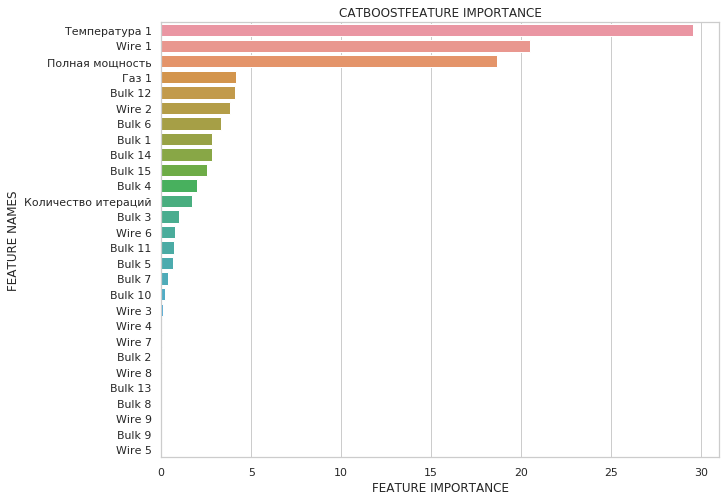

In [61]:
plot_feature_importance(model_cb.get_feature_importance(), X_test.columns,'CATBOOST')

Как видно из графика, самыми важными параметрами для модели CatBoostRegressor являются Температура 1, Wire 1 и Полная мощность

## Выводы

В данной работе нам предстояло оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» путем построения модели, которая предскажет температуру стали.

Для этого мы:
- Загрузили данные
- Провели первичный анализ данных
- Узнали больше информации о задаче
- Провели исследовательский анализ данных
- Сделали предобработку данных
- Подготовились к обучению моделей
- Провели обучение моделей
- Выбрали лучшую модель и протестировали ее на тестовой выборке с лучшими параметрами.
- Добились значения MAE =~6

В данной работе мы просто пытались угадать значение температуры исходя из некоторых факторов, но мы же знаем, что легкие колебания температуры есть всегда, а спрогнозировать их будет сложнее. 

Поэтому задачу экономии энергоресурсов можно поставить так: надо уменьшить разброс в измерениях. В данном случае в температуре.
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.
А что, если фиксировать случаи, когда температура выходит за эти границы?
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству:
а что был за материал, что был за газ, какая бригада работала. И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. Ну и разрабатывать энергосберегательные мероприятия.